In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [28]:
df = pd.read_excel('DatosCacao_multivariado.xlsx')
print(df.head())

       Fecha   COP/kg      TRM  COP/kg (internacional)  Inflacion  \
0 2024-01-01  14271.7      NaN                     NaN       8.35   
1 2024-01-08  14223.3  3912.93                16092.12       8.35   
2 2024-01-15  14086.3  3901.38                17102.48       8.35   
3 2024-01-22  14329.2  3916.39                17909.81       8.35   
4 2024-01-29  14530.8  3925.26                18449.86       8.35   

   COP/kg (futuro)   Produccion  
0              NaN  6995.448155  
1         15859.11  6995.448155  
2         16854.62  6995.448155  
3         17707.29  6995.448155  
4         18378.07  6995.448155  


In [29]:
# 2. Genera los lags y features supervisados
def create_supervised(df, target_col, lags):
    df_supervised = df.copy()
    for i in range(1, lags+1):
        df_supervised[f'{target_col}_lag_{i}'] = df_supervised[target_col].shift(i)
    df_supervised = df_supervised.dropna()
    return df_supervised

df_supervised = create_supervised(df, 'COP/kg', lags=2)


In [30]:
# 3. Definir features y target
features = [col for col in df_supervised.columns if col not in ['COP/kg', 'Fecha']]
X = df_supervised[features]
y = df_supervised['COP/kg']

In [31]:
# 4. División 80/20
split = int(0.8 * len(df_supervised))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [32]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 7, 8, 9, 26, 52]
}

tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)

print("Mejores parámetros:", search.best_params_)

Mejores parámetros: {'max_depth': 7, 'n_estimators': 400}


In [33]:
# 5. Construye y entrena el modelo
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


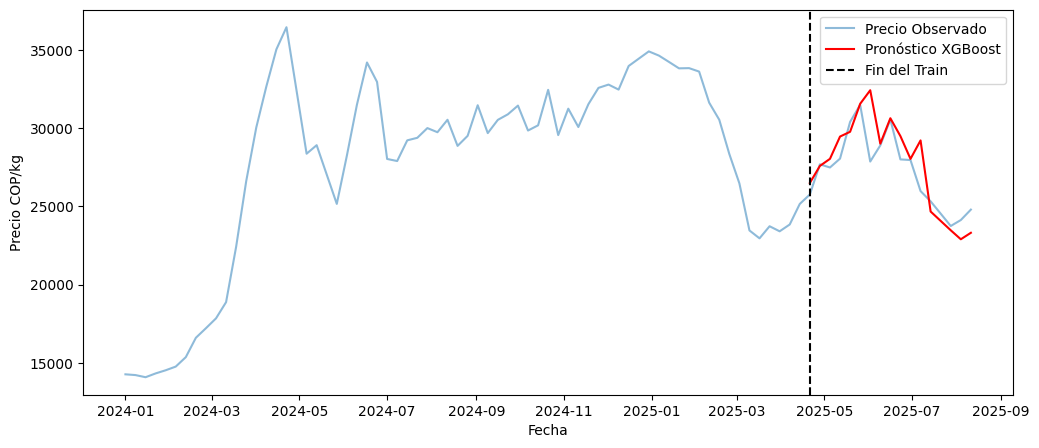

RMSE en test: 1599.24


In [34]:
# 6. Predice y grafica resultados
y_pred = model.predict(X_test)

# Fechas/valores de train y test usando los índices de las series supervisadas
train_dates = df.loc[y_train.index, 'Fecha']
test_dates = df.loc[y_test.index, 'Fecha']
pred_series = pd.Series(y_pred, index=y_test.index)


plt.figure(figsize=(12,5))

plt.plot(df["Fecha"], df["COP/kg"], label='Precio Observado', color='C0', alpha=0.5)
plt.plot(test_dates, pred_series.values, label='Pronóstico XGBoost', color='red')
plt.axvline(df["Fecha"].iloc[-len(test_dates)], color='k', linestyle='--', label='Fin del Train')

plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Precio COP/kg")
plt.show()

# 7. Métrica de error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE en test: {rmse:.2f}')

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
me = np.mean(y_test - y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"ME (sesgo): {me:.2f}")
print(f"R²: {r2:.2f}")

MAE: 1042.20
MSE: 2557552.91
RMSE: 1599.24
MAPE: 3.90%
ME (sesgo): -496.09
R²: 0.48
